In [7]:
# %% Veri Yükleme ve Ön İşleme
import numpy as np  # Sayısal işlemler için kütüphane
import matplotlib.pyplot as plt  # Grafik çizimi için kütüphane

# Scikit-learn kütüphanesinden gerekli modüller
from sklearn.datasets import load_digits  # Hazır el yazısı rakam verisetini yüklemek için
from sklearn.model_selection import train_test_split, GridSearchCV  # Veriyi eğitim/teste ayırmak ve model optimizasyonu için
from sklearn.preprocessing import StandardScaler  # Veriyi standardize etmek için
from sklearn.decomposition import PCA  # Boyut indirgeme yöntemi
from sklearn.svm import SVC  # Destek vektör makineleri (SVM) sınıflandırıcısı
from sklearn.ensemble import RandomForestClassifier, VotingClassifier  # Rastgele orman ve topluluk (ensemble) sınıflandırıcıları
from sklearn.neighbors import KNeighborsClassifier  # K-En Yakın Komşu sınıflandırıcısı
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Karışıklık matrisi ve görselleştirmesi

# Veriyi Yükle
digits = load_digits()  # El yazısı rakamlardan oluşan veri kümesini yükle
X, y = digits.data, digits.target  # Özellikleri X'e, hedef etiketleri y'ye ata

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  # %80 eğitim, %20 test verisi

# Veriyi standardize et (her özelliğin ortalamasını 0, std'sini 1 yap)
scaler = StandardScaler()  # StandardScaler nesnesini oluştur
X_train_scaled = scaler.fit_transform(X_train)  # Eğitim verisini fit et ve dönüştür
X_test_scaled = scaler.transform(X_test)  # Test verisini sadece dönüştür (fit yok!)

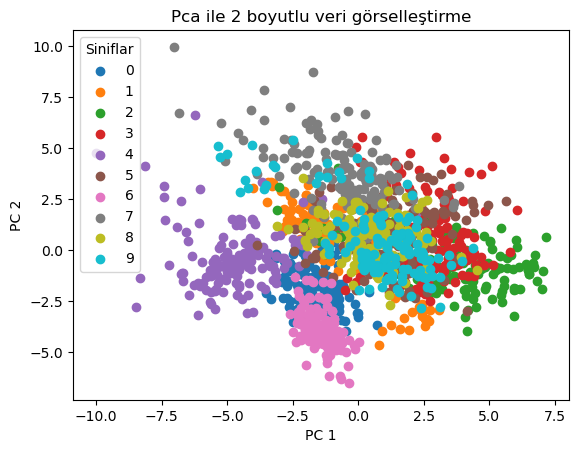

In [13]:
# PCA ile boyut indirgeme (dimension reduction)
pca = PCA(n_components = 0.95)  # Varyansın %95’ini koruyacak şekilde bileşen sayısını otomatik belirleyen PCA nesnesi oluşturuluyor
X_train_pca = pca.fit_transform(X_train_scaled)  # PCA modeli eğitiliyor ve eğitim verisi %95 varyansla boyut indirgenmiş hale getiriliyor
X_test_pca = pca.transform(X_test_scaled)  # Test verisi aynı PCA modeli kullanılarak dönüştürülüyor

# Veriyi sadece 2 boyuta indirip görselleştirme için ayrı bir PCA modeli
pca_2d = PCA(n_components = 2)  # Görselleştirme amacıyla veriyi yalnızca 2 boyuta indirgeyen PCA nesnesi
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)  # Eğitim verisi 2 boyuta indirgeniyor
X_test_pca_2d = pca_2d.transform(X_test_scaled)  # Test verisi de aynı şekilde 2 boyuta indirgeniyor

plt.figure()  # Yeni bir grafik figürü başlatılıyor
for i in np.unique(y_train):  # Her bir sınıf için döngüye giriliyor
    plt.scatter(
        X_train_pca_2d[y_train == i, 0],  # x ekseni için 1. ana bileşen (PC1)
        X_train_pca_2d[y_train == i, 1],  # y ekseni için 2. ana bileşen (PC2)
        label = digits.target_names[i]   # Sınıf etiketleri legend’da gösterilecek şekilde atanıyor
    )

plt.xlabel("PC 1")  # x ekseni etiketi: Ana bileşen 1
plt.ylabel("PC 2")  # y ekseni etiketi: Ana bileşen 2
plt.title("Pca ile 2 boyutlu veri görselleştirme")  # Grafik başlığı
plt.legend(title = "Siniflar", loc = "best")  # Sınıf etiketlerini en uygun yerde göster
plt.show()  # Grafiği ekrana çiz

In [25]:
# model training and grid search

# SVM için hiperparametreler: C değeri ve kernel türü belirleniyor
svm_params = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]} # SVM modelinin C (ceza parametresi) ve kernel türlerini (lineer veya rbf) belirler.
svm_grid = GridSearchCV(svm, svm_params, cv=5)  # GridSearch ile en iyi parametreler 5 katlı çapraz doğrulama ile aranıyor
svm_grid.fit(X_train_pca, y_train)  # SVM modeli eğitim verisi ile eğitiliyor

# Random Forest için hiperparametre: ağaç sayısı tanımlanıyor
rf_params = {"n_estimators": [50, 100, 200]}  # "n:estimators" yerine "n_estimators"
rf = RandomForestClassifier(random_state=42)  # Random Forest modeli oluşturuluyor (random_state sabit)
rf_grid = GridSearchCV(rf, rf_params, cv=5)  # RF için GridSearch ile en iyi parametreler aranıyor
rf_grid.fit(X_train_pca, y_train)  # RF modeli eğitim verisi ile eğitiliyor

# KNN için hiperparametre: komşu sayısı tanımlanıyor
knn_params = {"n_neighbors": [3, 5, 7]}  # KNN için komşu sayıları belirleniyor
knn = KNeighborsClassifier()  # KNN sınıflandırıcısı oluşturuluyor
knn_grid = GridSearchCV(knn, knn_params, cv=5)  # KNN için GridSearch ile en iyi parametre aranıyor
knn_grid.fit(X_train_pca, y_train)  # KNN modeli eğitim verisi ile eğitiliyor

# En iyi hiperparametrelerle elde edilen modeller seçiliyor
best_svm = svm_grid.best_estimator_  # GridSearch sonrası en iyi SVM modeli
best_rf = rf_grid.best_estimator_  # GridSearch sonrası en iyi RF modeli
best_knn = knn_grid.best_estimator_  # GridSearch sonrası en iyi KNN modeli

In [29]:
# Voting classifier
voting_clf = VotingClassifier(estimators=[  # Birkaç modelden oluşan bir ensemble sınıflandırıcı oluşturuluyor
    ("svm", best_svm),  # SVM modeli
    ("rf", best_rf),    # Random Forest modeli
    ("knn", best_knn)],  # KNN modeli
    voting="hard")  # Oylama türü: Hard (Çoğunluk oylaması)
voting_clf.fit(X_train_pca, y_train)  # Ensemble model eğitiliyor

y_pred = voting_clf.predict(X_test_pca)  # Test verisi ile tahmin yapılır

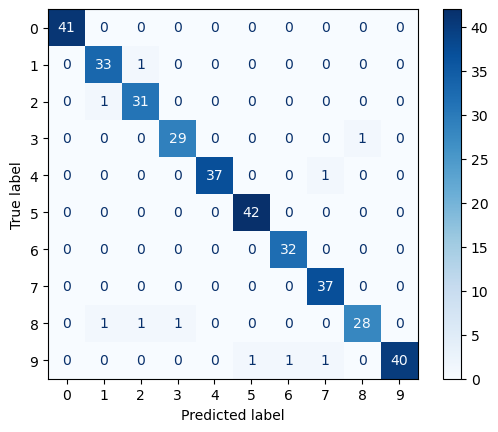

Best svm params: {'C': 1, 'kernel': 'rbf'}
Best rf params: {'n_estimators': 100}
Best knn params: {'n_neighbors': 3}
Voting classifier accuracy: 0.9722222222222222


In [39]:
# Sonuçların değerlendirilmesi
cm = confusion_matrix(y_test, y_pred)  # Confusion matrix hesaplanıyor

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)  # Confusion matrix görselleştiriliyor
disp.plot(cmap=plt.cm.Blues)  # Görselleştirme renk paleti seçiliyor
plt.show()

print(f"Best svm params: {svm_grid.best_params_}")  # En iyi SVM hiperparametreleri yazdırılıyor
print(f"Best rf params: {rf_grid.best_params_}")  # En iyi RF hiperparametreleri yazdırılıyor
print(f"Best knn params: {knn_grid.best_params_}")  # En iyi KNN hiperparametreleri yazdırılıyor
print(f"Voting classifier accuracy: {voting_clf.score(X_test_pca, y_test)}")  # Voting classifier doğruluğu yazdırılıyor

"""
Best svm params: {'C': 1, 'kernel': 'rbf'}
Best rf params: {'n_estimators': 100}
Best knn params: {'n_neighbors': 3}
Voting classifier accuracy: 0.9722222222222222
"""